In [31]:
!pip install --upgrade yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     -------------------------------------- 948.2/948.2 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139014 sha256=6d0e1d45b434214572f5660e3fae14fba840501583eaf298d0e533594757ce95
  Stored in directory: c:\users\matth\appdata\local\pip\cache\wheels\8f\65\34\456800445efeafb05164fe95285c70e81ba1

In [33]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf

In [37]:
endDate = datetime.datetime.now() - datetime.timedelta(days=2)
startDate = endDate - datetime.timedelta(days=300)

stockData = yf.download('GOOG', startDate, endDate)
stockData = stockData['Close']
returns = stockData.pct_change()
meanReturns = returns.mean()
covMatrix = returns.cov()

[*********************100%***********************]  1 of 1 completed


In [49]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['GOOG', 'AAPL', 'NVDA', 'MOS', 'MU', 'OXY']
endDate = datetime.datetime.now() - datetime.timedelta(days=2)
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix= get_data('GOOG', startDate, endDate)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  6 of 6 completed


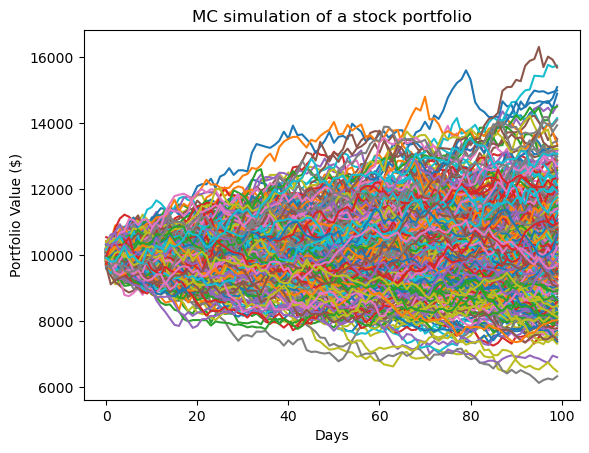

VaR_5 $2060.83
CVaR_5 $2555.21


In [59]:
#Define the function for importing stock data and computing mean/covariance
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

#Example: 
stockList = ['GOOG', 'AAPL', 'NVDA', 'MOS', 'MU', 'OXY']
endDate = datetime.datetime.now() - datetime.timedelta(days=2)
startDate = endDate - datetime.timedelta(days=300)
meanReturns, covMatrix= get_data(stockList, startDate, endDate)


weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

In [67]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


In [69]:

#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.87 with SE +/- 0.11


In [71]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.86 with SE +/- 0.11


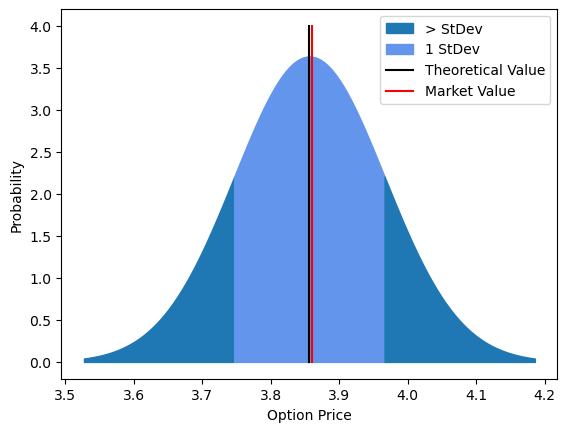

In [73]:

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()